# LAB 4: Quantization


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = torch.device('cpu')

## Get the dataset

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Model Declaration

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

## Training 

In [7]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            #print(images.size())
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [8]:
train(net, trainloader)

[1,  2000] loss: 2.196
[1,  4000] loss: 1.937
[1,  6000] loss: 1.727
[1,  8000] loss: 1.643
[1, 10000] loss: 1.560
[1, 12000] loss: 1.522
[2,  2000] loss: 1.458
[2,  4000] loss: 1.413
[2,  6000] loss: 1.397
[2,  8000] loss: 1.391
[2, 10000] loss: 1.359
[2, 12000] loss: 1.322
Finished Training


In [9]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 51.84%


## Visualization of weights distribution

In [10]:
def all_params(model):
    params = torch.Tensor()
    for param in net.parameters():
        params = torch.cat([params, param.flatten().detach()])
    return params

In [11]:
def params_report(params):
    mean = params.mean()
    std = params.std()

    print(f"n: {len(params)}")
    print(f"min: {params.min()}")
    print(f"max: {params.max()}")
    print(f"3-sigma range: [{mean - 3 * std}, {mean + 3 * std}]")

    plt.hist(params, bins=100)
    plt.show()

n: 61770
min: -0.6724898219108582
max: 0.658996045589447
3-sigma range: [-0.16994927893392742, 0.16403681715019047]


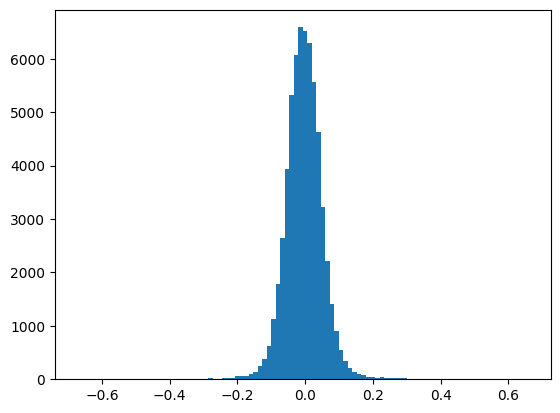

In [12]:
params = all_params(net)
params_report(params.numpy())

## Post training quantization: Weights

In [13]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [14]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor, target_range: float = 127.0) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights
    target_range (float): The desired range for the quantized values. Default is 127.0.

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''
    scale = 127 / target_range
    params = torch.clamp(weights, -target_range, target_range)
    params = params * scale
    params = torch.round(params)
    
    return params, scale

In [15]:
print(params.max())
quantized_weights(weights=params, target_range=3 * params.std())[0].max()

tensor(0.6590)


tensor(127.)

In [16]:
net_q2 = copy_model(net)

In [17]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data, layer.weight.max())

            print("min", layer.weight.min())
            print("max", layer.weight.max())
            print("3std", 3 * layer.weight.std(), end="\n\n")
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

min tensor(-0.6725, grad_fn=<MinBackward1>)
max tensor(0.6590, grad_fn=<MaxBackward1>)
3std tensor(0.5970, grad_fn=<MulBackward0>)

min tensor(-0.3790, grad_fn=<MinBackward1>)
max tensor(0.3896, grad_fn=<MaxBackward1>)
3std tensor(0.3316, grad_fn=<MulBackward0>)

min tensor(-0.2309, grad_fn=<MinBackward1>)
max tensor(0.2701, grad_fn=<MaxBackward1>)
3std tensor(0.1289, grad_fn=<MulBackward0>)

min tensor(-0.2275, grad_fn=<MinBackward1>)
max tensor(0.2318, grad_fn=<MaxBackward1>)
3std tensor(0.1929, grad_fn=<MulBackward0>)

min tensor(-0.3743, grad_fn=<MinBackward1>)
max tensor(0.4100, grad_fn=<MaxBackward1>)
3std tensor(0.3847, grad_fn=<MulBackward0>)



In [18]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 51.77%


In [35]:
## Print the size of the model
## ADD YOUR CODE HERE

print(torchinfo.summary(net, input_size=(3, 32, 32)))
print(torchinfo.summary(net_q2, input_size=(3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [6, 28, 28]               450
├─MaxPool2d: 1-2                         [6, 14, 14]               --
├─Conv2d: 1-3                            [16, 10, 10]              2,400
├─MaxPool2d: 1-4                         [16, 5, 5]                --
├─Linear: 1-5                            [1, 120]                  48,000
├─Linear: 1-6                            [1, 84]                   10,080
├─Linear: 1-7                            [1, 10]                   840
Total params: 61,770
Trainable params: 61,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.52
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]    

## Quantization activations

In [ ]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [ ]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

### Visualize activation distribution

In [ ]:
# ADD YOUR CODE HERE: to plot activation distribution
# You can access the activation matrice like this:
# net_q3.input_activations
# net_q3.conv1_activations
# ....

### Quantize activations

In [ ]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(initial_input: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        initial_input (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD your code here

        return scale_factor

    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        s_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        s_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the next layer.
               This value does not need to be an 8-bit integer.
        '''
        # ADD YOUR CODE HERE
       
        return scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale
        # You don't need to quantize Relu outputs 

        # ADD YOUR CODE HERE (Replace the ...)
        # ...
        x = self.pool(F.relu(x))
        x = torch.clamp(x, min=-128, max=127)
        # ...
        x = self.pool(F.relu(x))
        x = torch.clamp(x, min=-128, max=127)
        # ...
        x = x.view(-1, 16 * 5 * 5)
        # ...
        x = F.relu(x)
        # ...
        x = F.relu(x)
        # ...

        return x

In [ ]:
# Merge the information from net_q2 and net_q3 together

net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [ ]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))